In [1]:
import sys
sys.path.insert(0, "../")
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from peakfitting.peaks import find_local_peaks, refine_peaks



In [2]:
data_dir = "../simulation_data/test_params_MoS2_layers_8-test/fitting_parameters/"


data = np.load(data_dir+"sigmas.npz", allow_pickle=True)

ground_truth = data["gt"]
prediction = data["pred"]
temp = data["temp"]
N = temp.shape[0]


In [3]:
sigmas = np.empty(shape=(2, N))
for i in range(N):
    if i % 100 == 0:
        print("System {:>3}\n has shape ({:>3},) and mean {:.5f}".format(i, ground_truth[i].shape[0], ground_truth[i].mean()))
    sigmas[0, i] = ground_truth[i].mean()
    sigmas[1, i] = prediction[i].mean()

System   0
 has shape (357,) and mean 1.90712
System 100
 has shape (547,) and mean 2.13832
System 200
 has shape (159,) and mean 1.95856
System 300
 has shape (370,) and mean 1.93989
System 400
 has shape ( 54,) and mean 1.92320
System 500
 has shape (477,) and mean 1.86880
System 600
 has shape (109,) and mean 2.09283
System 700
 has shape (325,) and mean 2.21324
System 800
 has shape (316,) and mean 2.14670
System 900
 has shape (150,) and mean 1.98998


In [4]:
gt_sep = np.empty(shape=(2, N))
for n in range(N):
    mu = ground_truth[n].mean()
    gt_sep[0, n] = ground_truth[n][ground_truth[n] <= mu].mean()
    gt_sep[1, n] = ground_truth[n][ground_truth[n] > mu].mean()


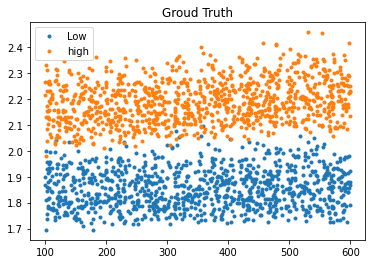

In [5]:
plt.title("Groud Truth")
plt.plot(temp, gt_sep[0], '.')
plt.plot(temp, gt_sep[1], '.')
plt.legend(["Low", "high"])
plt.show()

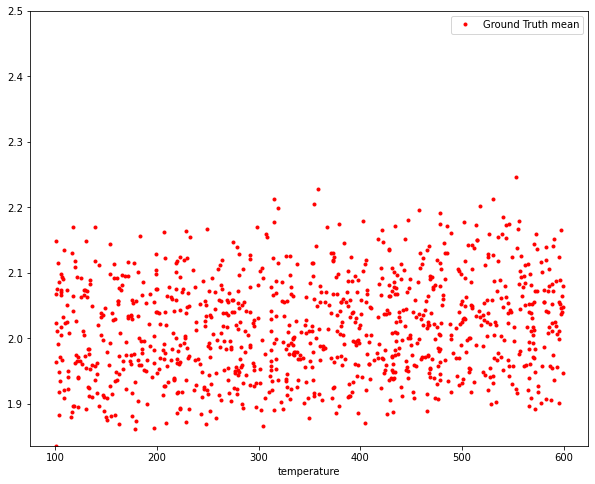

In [6]:
plt.figure(figsize=(10,8))
plt.plot(temp, sigmas[0], '.r')
# plt.plot(temp, sigmas[1], '.b')
plt.ylim([sigmas.min(), 2.5])
plt.legend(["Ground Truth mean", "Prediction mean"])
plt.xlabel("temperature")
plt.show()

In [7]:
print(np.sort(sigmas[0])[:-5:-1].astype(float))
print(np.sort(sigmas[1])[:-5:-1].astype(float))

[2.2459928  2.22819289 2.2133687  2.21323931]
[1.43271008e+04 2.13387446e+00 2.13186528e+00 2.12808309e+00]


In [8]:
print("weird max at sigmas{} = {}".format( np.argwhere(sigmas == np.max(sigmas)).squeeze(), np.max(sigmas)))

weird max at sigmas[  1 692] = 14327.100772409574


In [9]:
print(np.sort(prediction[692])[::-1])
print(np.sort(ground_truth[692])[::-1])

[1.62029027e+07 7.30986243e+06 3.01019051e+06 ... 2.78178291e-01
 2.69190750e-01 2.59682630e-01]
[2.24168956 2.17801101 2.14705733 1.98046683 1.90406733 1.88583897]


In [10]:
# %ase gui ../workflow/simulation_data/test_params_MoS2_layers_8/model/model_0692.traj

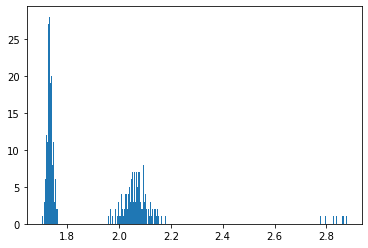

In [11]:
plt.hist(ground_truth[0], bins=len(ground_truth[0]))
plt.show()

## Debugging plot fitting

In [12]:
min_temps = np.sort(temp)[:4]
max_temps = np.sort(temp)[-5:-1]
max_temps
for i, _ in enumerate(max_temps):
    print("Min system:")
    print(np.argwhere(temp == min_temps[i]))
print()
for i, _ in enumerate(max_temps):
    print("Max system: ")
    print(np.argwhere(temp == max_temps[i]))

Min system:
[[408]]
Min system:
[[780]]
Min system:
[[921]]
Min system:
[[948]]

Max system: 
[[542]]
Max system: 
[[454]]
Max system: 
[[128]]
Max system: 
[[358]]


In [13]:
# %grep "\"Temp\": 1" ../workflow/simulation_data/test_params_MoS2_layers_8-test/tem_params/*

In [14]:
min_sys = [408, 780, 921, 948]
max_sys = [542, 454, 128, 358]
waves_min = []
waves_max = []
data_dir = "../simulation_data/test_params_MoS2_layers_8-test/images_labels/"
for i, (mi, ma) in enumerate(zip(min_sys, max_sys)):
    imagenumber = "{:04d}".format(mi)
    print("Iteration:", i)
    tem_params = np.load(os.path.join(data_dir, "image_label_000_"+imagenumber+".npz"))
    waves_min.append(tem_params['label'])
    
    imagenumber = "{:04d}".format(ma)
    tem_params = np.load(os.path.join(data_dir, "image_label_000_"+imagenumber+".npz"))
    waves_max.append(tem_params['label'])
    
waves_min = np.asarray(waves_min).squeeze()
waves_max = np.asarray(waves_max).squeeze()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [15]:
imag_min = waves_min[..., 1]
imag_max = waves_max[..., 1]

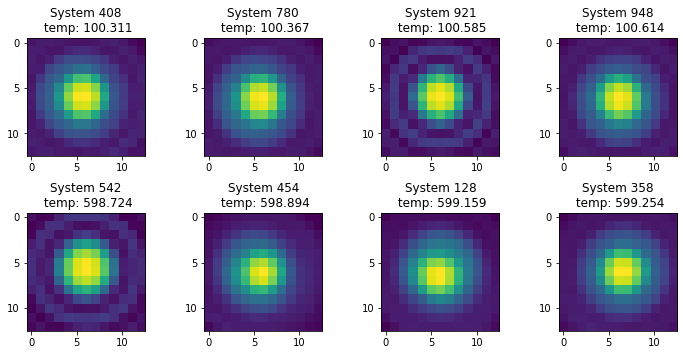

In [16]:
offset = 6
# region = np.ones(shape=(offset+1, offset+1)).astype(bool)
fig, ax = plt.subplots(2, len(min_sys), figsize=(10, 5))
for i, (mi, ma) in enumerate(zip(imag_min, imag_max)):
    # Find peaks
    peaks_min = find_local_peaks(image=mi,
                            min_distance=10,
                            threshold=0.3,
                            exclude_border=10,
                            exclude_adjacent=True).astype(int)
    some_peak_min = peaks_min[0]
    peaks_max = find_local_peaks(image=ma,
                            min_distance=10,
                            threshold=0.3,
                            exclude_border=10,
                            exclude_adjacent=True).astype(int)
    some_peak_max = peaks_max[0]
    
    ax[0, i].imshow(mi[some_peak_min[0]-offset:some_peak_min[0]+offset+1, 
                       some_peak_min[1]-offset:some_peak_min[1]+offset+1])
    ax[0, i].set_title("System {:}\n temp: {:.3f}".format(min_sys[i], min_temps[i]))
    ax[1, i].plot(range(some_peak_min[1]-offset, some_peak_min[1]+offset+1), 
                  mi[some_peak_min[0], some_peak_min[1]-offset:some_peak_min[1]+offset+1], '.')
    
    ax[1, i].imshow(ma[some_peak_max[0]-offset:some_peak_max[0]+offset+1,
                       some_peak_max[1]-offset:some_peak_max[1]+offset+1])
    ax[1, i].set_title("System {:}\n temp: {:.3f}".format(max_sys[i], max_temps[i]))
plt.tight_layout()
plt.show()

Determining min 0


100%|██████████| 437/437 [00:01<00:00, 242.86it/s]


Determining max 0


100%|██████████| 202/202 [00:00<00:00, 227.23it/s]


Determining min 1


100%|██████████| 289/289 [00:01<00:00, 228.54it/s]


Determining max 1


100%|██████████| 483/483 [00:01<00:00, 261.18it/s]


Determining min 2


100%|██████████| 180/180 [00:00<00:00, 231.70it/s]


Determining max 2


100%|██████████| 358/358 [00:01<00:00, 246.37it/s]


Determining min 3


100%|██████████| 367/367 [00:01<00:00, 245.75it/s]


Determining max 3


100%|██████████| 198/198 [00:00<00:00, 233.80it/s]


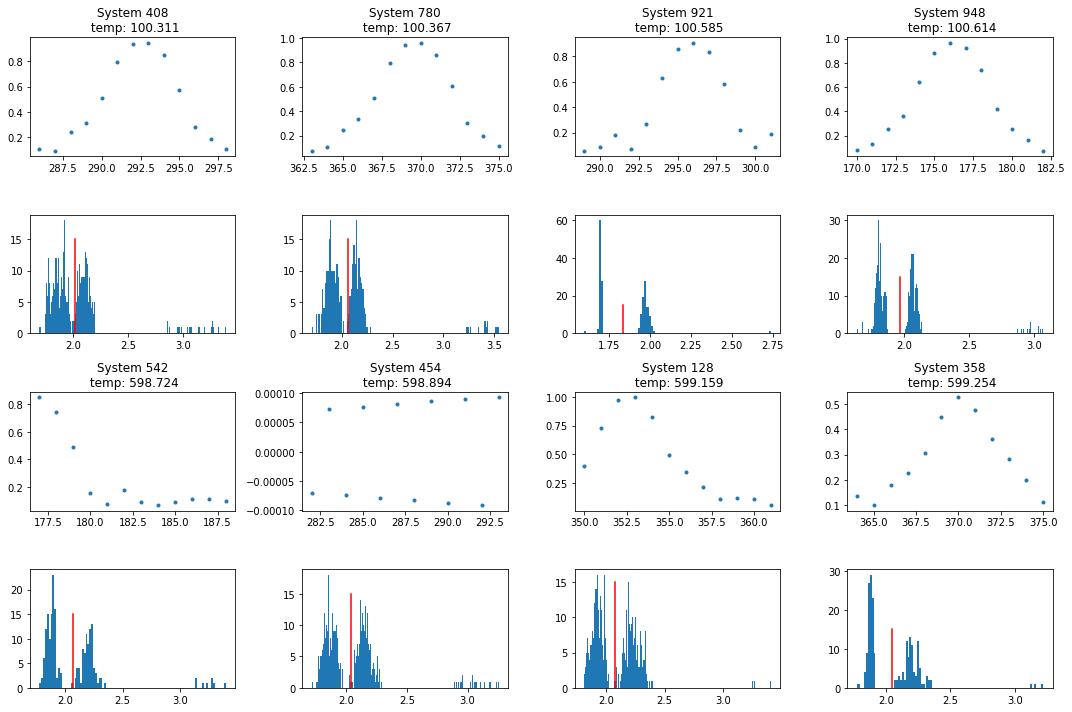

In [17]:
fig, ax = plt.subplots(4, len(min_sys), figsize=(15, 10))
for i, (mi, ma) in enumerate(zip(imag_min, imag_max)):
    ## Peaks
    peaks_min = find_local_peaks(image=mi,
                                min_distance=10,
                                threshold=0.3,
                                exclude_border=10,
                                exclude_adjacent=True).astype(int)
    print(f"Determining min {i}")
    min_re, sigma_min = refine_peaks(image=mi,
                          points=peaks_min,
                          region=11,
                          model="gaussian",
                          progress_bar=True)
    some_peak_min = min_re[0].astype(int)
    ## Plot of values through middle
    ax[0, i].plot(range(some_peak_min[1]-offset, some_peak_min[1]+offset+1), 
                  mi[some_peak_min[0], some_peak_min[1]-offset:some_peak_min[1]+offset+1], '.')
    ax[0, i].set_title("System {:}\n temp: {:.3f}".format(min_sys[i], min_temps[i]))
    ## Histogram
    ax[1, i].hist(sigma_min, bins=len(sigma_min)//2)
    ax[1, i].plot([sigma_min.mean()]*2, [0,15], '-r')
    peaks_max = find_local_peaks(image=ma,
                                 min_distance=10,
                                 threshold=0.3,
                                 exclude_border=10,
                                 exclude_adjacent=True).astype(int)
    print(f"Determining max {i}")
    ## Peaks
    max_re, sigma_max = refine_peaks(image=ma,
                          points=peaks_max,
                          region=11,
                          model="gaussian",
                          progress_bar=True)
    some_peak_max = max_re[0].astype(int)
    
    ## Plot of values through middle
    ax[2, i].plot(range(some_peak_max[1]-offset, some_peak_max[1]+offset), 
                  mi[some_peak_max[0], some_peak_max[1]-offset:some_peak_max[1]+offset], '.')
    ax[2, i].set_title("System {:}\n temp: {:.3f}".format(max_sys[i], max_temps[i]))
    
    ## Histogram
    ax[3, i].hist(sigma_max, bins=len(sigma_max)//2)
    ax[3, i].plot([sigma_max.mean()]*2, [0, 15], '-r')

plt.tight_layout()
plt.show()

(640, 640) (640, 640)
Determining min 0


100%|██████████| 437/437 [00:01<00:00, 241.92it/s]


Determining max 0


100%|██████████| 202/202 [00:00<00:00, 227.94it/s]


(640, 640) (640, 640)
Determining min 1


100%|██████████| 289/289 [00:01<00:00, 232.68it/s]


Determining max 1


100%|██████████| 483/483 [00:01<00:00, 257.46it/s]


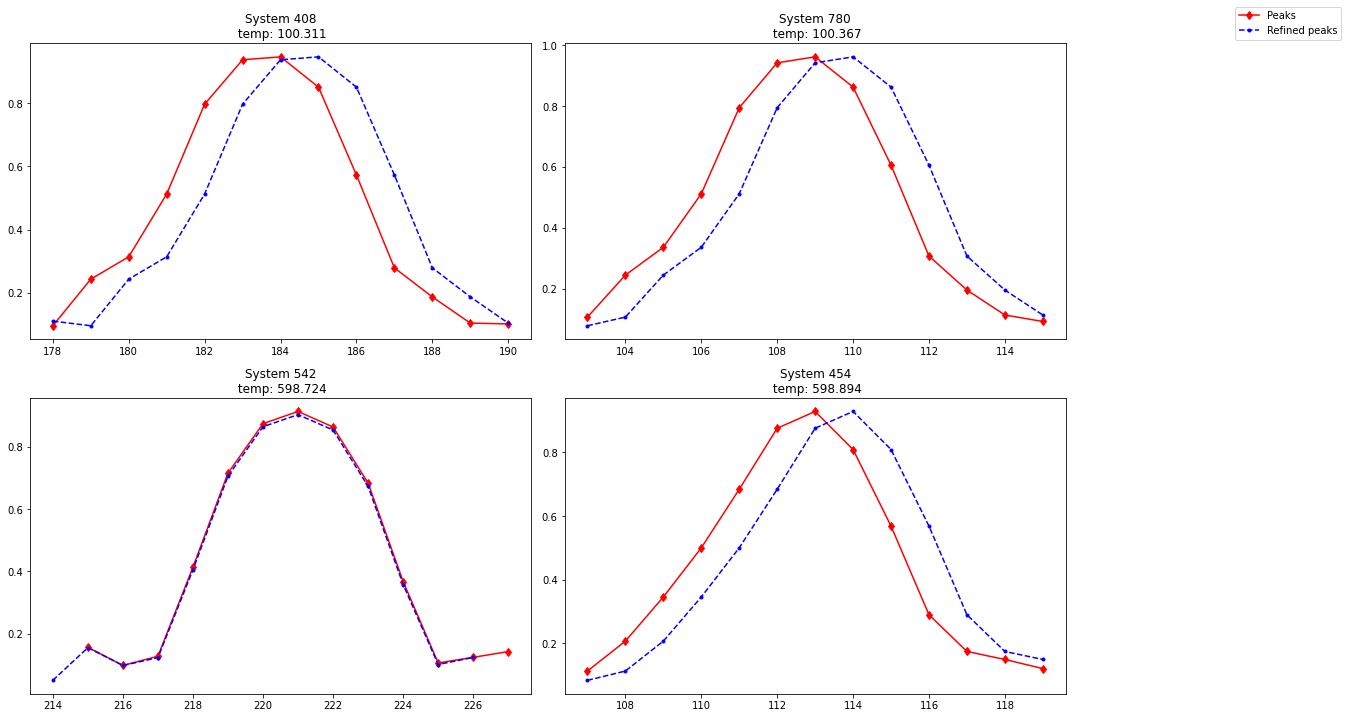

In [18]:
fig, ax = plt.subplots(2, len(min_sys)//2, figsize=(15,10))
imag_min2 = imag_min[:2]
imag_max2 = imag_max[:2]

offset = 6
x = lambda peak: range(peak[0].astype(int) - offset, peak[0].astype(int) + offset + 1)
y = lambda image, peak: image[peak[0].astype(int), peak[1].astype(int) - offset : peak[1].astype(int) + offset + 1]


for i, (mi, ma) in enumerate(zip(imag_min2, imag_max2)):
    print(mi.shape, ma.shape)
    peaks_min = find_local_peaks(image=mi, min_distance=10, threshold=0.3, exclude_border=10, exclude_adjacent=True).astype(int)
    min_peak = peaks_min[0]
    
    print(f"Determining min {i}")
    
    min_re, sigma_min = refine_peaks(image=mi, points=peaks_min, region=11, model="gaussian", progress_bar=True)
    min_peak_re = min_re[0]
    
    ax[0, i].plot(x(min_peak), y(mi, min_peak), 'd-r')
    ax[0, i].plot(x(min_peak_re), y(mi, min_peak_re), '.--b')
    ax[0, i].set_title("System {:}\n temp: {:.3f}".format(min_sys[i], min_temps[i]))
    
    peaks_max = find_local_peaks(image=ma, min_distance=10, threshold=0.3, exclude_border=10, exclude_adjacent=True).astype(int)
    max_peak = peaks_max[0]
    print(f"Determining max {i}")
    
    max_re, sigma_max = refine_peaks(image=ma, points=peaks_max, region=11, model="gaussian", progress_bar=True)
    max_peak_re = max_re[0].astype(int)
    
    ax[1, i].plot(x(max_peak),    y(ma, max_peak),    'd-r')
    ax[1, i].plot(x(max_peak_re), y(ma, max_peak_re), '.--b')
    ax[1, i].set_title("System {:}\n temp: {:.3f}".format(max_sys[i], max_temps[i]))
    
fig.legend(["Peaks", "Refined peaks"], bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()